## netCDF: Importing netCDF files, extracting desired data and bringing it into a desired format

In this file I will itterativly try to load and understand the structure of the by anemos delivered netCDF wind data.

1. I am going to install and load all the necessary packages to work with and analyse netCDF data

In [16]:
import xarray as xr
import timeit
import pandas as pd
import numpy as np
import numba
#import asyncio
#import hvplot.xarray
import cartopy.crs as ccrs
import sys

def format_bytes(size):
    # 2**10 = 1024
    power = 2**10
    n = 0
    power_labels = {0 : '', 1: 'kilo', 2: 'mega', 3: 'giga', 4: 'tera'}
    while size > power:
        size /= power
        n += 1
    return size, power_labels[n]+'bytes'

import matplotlib.pyplot as plt

print(xr.__version__)

0.20.2


# Loading a netCDF file with the xarray package

In [44]:
#path = r"windData/wdirC.7L.2017-T.ts.nc"
year = 2017
nc_data_path = f"/uba/anemos_winddata/20191029_anemosDataFull/UBA-Windatlas/NC-Format/wspd.10L.{year}.nc"
tsnc_data_path = f"/uba/anemos_winddata/20191029_anemosDataFull/UBA-Windatlas/TSNC-Format/wspd.10L.{year}.ts.nc"

start = timeit.default_timer()

data = xr.open_dataset(tsnc_data_path, engine='h5netcdf')
# for multiple files
#data = xr.open_mfdataset(nc_data_path, chunks={'time': 100}, parallel=True, engine='h5netcdf')

stop = timeit.default_timer()

print(f'Loadingtme for netCDF-file: {stop - start}')
size = format_bytes(sys.getsizeof(data))
print(f"Size of loaded file: {size}")
data

Loadingtme for netCDF-file: 0.08112139697186649
Size of loaded file: (112, 'bytes')


<xarray.Dataset>
Dimensions:  (y: 310, x: 225, time: 52560, level: 10)
Coordinates:
    lat      (y, x) float32 ...
    lon      (y, x) float32 ...
  * time     (time) datetime64[ns] 2017-01-01 ... 2017-12-31T23:50:00
  * x        (x) int16 0 1 2 3 4 5 6 7 8 ... 216 217 218 219 220 221 222 223 224
  * y        (y) int16 0 1 2 3 4 5 6 7 8 ... 301 302 303 304 305 306 307 308 309
  * level    (level) float32 40.0 60.0 80.0 100.0 ... 170.0 200.0 250.0 300.0
Data variables:
    wspd     (y, x, level, time) float32 ...
Attributes: (12/130)
    TITLE:                           D3E5
    START_DATE:                      2011-07-01_00:00:00
    SIMULATION_START_DATE:           2010-01-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        [256]
    SOUTH-NORTH_GRID_DIMENSION:      [352]
    BOTTOM-TOP_GRID_DIMENSION:       [50]
    ...                              ...
    ISOILWATER:                      [14]
    history:                         Thu Aug  8 14:07:48 2019: ncrcat -7 -L 3...
    NCO:                             4.4.2
    title:                           D3E5
    nco_openmp_thread_number:        [1]
    actual_range:                    [100. 100.]

## Replace `x,y` Dimensions 

Initially the `x,y` dimensions of the netCDF file where ranging from 0 to the number of raw or column. The grid is structured as a *lambert projection*, but the absolut values of `0,...` do not represent the correct coordinates. Therefore,  anemos send us the correct lambert projection coordinates, in order to assign them to the `x,y` dimensions. 

With the result we should be able to transform a `lon,lat` coordinate *(EPSG=4326)* to a lambert projection coordinate.

In [ ]:
# Load the new dimensional lambda coordinates
path = "xy_lamber_projection_values"

new_dim_coor = pd.read_csv(path)
new_dim_coor.head()

In [ ]:
# assign the new x,y values to the netCDF data
x = new_dim_coor["x"].dropna().astype("int").values
y = new_dim_coor["y"].values

data = data.assign_coords(
    coords={"x": x,"y": y}
)

### Using coordination transformation with projections to get exact `[x,y]` float equivalents to the multidimensional `[lon(x,y),lat(x,y)]`

#### *cartopy*: **NOT WORKING (same for anemos)**

In [ ]:
map_proj = ccrs.LambertConformal(
    central_longitude=data.CEN_LON[0], 
    central_latitude=data.CEN_LAT[0], 
    #false_easting=,
    #false_northing=,
    standard_parallels=(data.MOAD_CEN_LAT[0], data.STAND_LON[0]),
    #globe=None,
    #cutoff=-30
    )

x, y = map_proj.transform_point(47.2, 5.899, src_crs=ccrs.PlateCarree())
print(f"x:{x}, y:{y}")

#### *pyproj*: **WORKING (code and new `x,y` coordinates from anemos)**

In [ ]:
from pyproj import CRS, Transformer

crsD3E5 = CRS.from_proj4("+proj=lcc +lat_1=48.0 +lat_2=54.0 +lat_0=50.893 +lon_0=10.736 +a=6370000 +b=6370000 +nadgrids=null +no_defs")
crsGeo = CRS.from_epsg(4326)
geo2altas = Transformer.from_crs(crsGeo, crsD3E5)
lon = 10.0
lat = 50.0

#lon = point["coor"][1]
#lat = point["coor"][0]

x,y = geo2altas.transform(lat, lon)
print(f"x:{x}, y:{y}")
data.interp(x=x,y=y,level=110,time=f"{year}-03-29T19:30").load()

#### *gdal*: **WORKING (code and new `x,y` coordinates from anemos)**

In [ ]:
import ogr
import osr
d3e5Prj = osr.SpatialReference()
d3e5Prj.ImportFromProj4("+proj=lcc +lat_1=48.0 +lat_2=54.0 +lat_0=50.893 +lon_0=10.736 +a=6370000 +b=6370000 +nadgrids=null +no_defs")
geoPrj = osr.SpatialReference()
geoPrj.ImportFromEPSG(4326)
lon = 10.0
lat = 50.0

#lon = point["coor"][1]
#lat = point["coor"][0]

point = ogr.Geometry(ogr.wkbPoint)
point.AddPoint(lat, lon)
point.AssignSpatialReference(geoPrj)    # tell the point what coordinates it's in
point.TransformTo(d3e5Prj)              # project it to the out spatial reference
print(f'{point.GetX()},{point.GetY()}')
data.interp(x=point.GetX(),y=point.GetY(),level=110,time=f"{year}-03-29T19:30").load()

## Putting together a function to perform the coordinate transformation

In [19]:
def coor_transformation(coor:list,engine:str="pyproj")->list:
    lambert_proj_str = "+proj=lcc +lat_1=48.0 +lat_2=54.0 +lat_0=50.893 +lon_0=10.736 +a=6370000 +b=6370000 +nadgrids=null +no_defs"

    if engine == "pyproj":
        from pyproj import CRS, Transformer

        crsD3E5 = CRS.from_proj4(lambert_proj_str)
        crsGeo = CRS.from_epsg(4326)
        geo2altas = Transformer.from_crs(crsGeo, crsD3E5)

        x,y = geo2altas.transform(coor[0], coor[1])
        return[x,y]

    if engine == "gdal":
        from ogr import Geometry
        from osr import SpatialReference
        
        d3e5Prj = SpatialReference()
        d3e5Prj.ImportFromProj4(lambert_proj_str)
        geoPrj = SpatialReference()
        geoPrj.ImportFromEPSG(4326)

        point = Geometry(ogr.wkbPoint)
        point.AddPoint(coor[0], coor[1])
        point.AssignSpatialReference(geoPrj)    # tell the point what coordinates it's in
        point.TransformTo(d3e5Prj)              # project it to the out spatial reference
        return[point.GetX(),point.GetY()]

# Trying Coordinate Search

In [ ]:
ds = data.sel(level=120,time=f"{year}-03-29T19:30")
ds.wspd.plot(x='lon', y='lat', figsize=(13,13))
plt.scatter(ds.lon, ds.lat, s = 0.2)

In [ ]:
# A 2D plot of the SPEED variable, assigning the coordinate values,
# and plot the verticies of each point
dsplot = ds.where((lon-0.1 < data.lon) & (data.lon < lon+0.1) & (lat-0.1 < data.lat) & (data.lat < lat+0.1), drop=True)
dsplot.wspd.plot(x='lon', y='lat', figsize=(6,6))
plt.scatter(dsplot.lon, dsplot.lat)#, s = 0.2)

lon = 10.0
lat = 50.0

[x_interp,y_interp] = coor_transformation(coor=[lat,lon])
#print(x_interp,y_interp)

# Plot requested lat/lon point blue
plt.scatter(lon, lat, color='b')
plt.text(lon, lat, 'requested')

# Plot nearest point in the array red
ds_near = ds.interp(x=x_interp, y=y_interp, method="nearest")
plt.scatter(ds_near.lon, ds_near.lat, color='r')
plt.text(ds_near.lon, ds_near.lat, 'nearest')
#ds_near.load()

# Plot interpolation value
ds_interp = ds.interp(x=x_interp, y=y_interp, method="linear")
plt.scatter(ds_interp.lon, ds_interp.lat, color='y', marker="x")
plt.text(ds_interp.lon, ds_interp.lat, 'interp')
ds_interp.load()

plt.title('speed at nearest interpolated point: %s' % ds_interp.wspd.data)

## Plotting time series

### mfdataset Xarray

In [ ]:
# .nc data
year = 2017
lon = 10.0
lat = 50.
[x_interp,y_interp] = coor_transformation(coor=[lat,lon], engine="pyproj")

# Load the new dimensional lambda coordinates
path = "xy_lamber_projection_values"
new_dim_coor = pd.read_csv(path)
# assign the new x,y values to the netCDF data
x = new_dim_coor["x"].dropna().astype("int").values
y = new_dim_coor["y"].values

# netCDF windatlas files
nc_data_path = f"/uba/anemos_winddata/20191029_anemosDataFull/UBA-Windatlas/NC-Format/wspd.10L.{year}.nc"
#nc_data_path = f"/uba/anemos_winddata/20191029_anemosDataFull/UBA-Windatlas/NC-Format/wspd.10L.*.nc"

with xr.open_mfdataset(nc_data_path, chunks={'time': 1000}, engine='h5netcdf', parallel=True) as nc_data:
    # assign the new x,y values to the netCDF data
    nc_data = nc_data.assign_coords(
        coords={"x": x,"y": y}
    )

    ts_interp = nc_data.interp(x=x_interp, y=y_interp, level=113, method="linear")

ts_interp#.wspd#.load().plot.line()

### not "mf"-dataset, instead list comprehension

In [ ]:
# .ts.nc data
years = np.arange(2009,2019,1)
#year = 2017
lon = 10.0
lat = 50.0
[x_interp,y_interp] = coor_transformation(coor=[lat,lon], engine="pyproj")

# load the new dimensional lambda coordinates
path = "xy_lamber_projection_values"
new_dim_coor = pd.read_csv(path)
# load the new x,y values to the netCDF data
x = new_dim_coor["x"].dropna().astype("int").values
y = new_dim_coor["y"].values

#@numba.jit(nopython=True)
def loading_year(
        year:int, 
        x:np.ndarray=x, 
        y:np.ndarray=y,
        x_interp:float=x_interp,
        y_interp:float=y_interp
        ):

    tsnc_data_path = f"/uba/anemos_winddata/20191029_anemosDataFull/UBA-Windatlas/TSNC-Format/wspd.10L.{year}.ts.nc"

    with xr.open_dataset(tsnc_data_path,engine='h5netcdf') as ts_nc_data:
        # assign the new x,y values to the netCDF data
        ts_nc_data = ts_nc_data.assign_coords(
            coords={"x": x,"y": y}
        )

        ts_interp = ts_nc_data.interp(x=x_interp, y=y_interp, level=113, method="linear")

    return ts_interp.wspd.load()

start = timeit.default_timer()

arrays = [loading_year(year=year) for year in years]

ts_interp = xr.concat(arrays, dim="time")

stop = timeit.default_timer()

del(arrays)
print(f'concattime for netCDF-query: {stop - start}')

ts_interp#.wspd#.plot.line(figsize=(13,5))

In [ ]:
type(ts_interp)

### not "mf"-dataset, instead for loop

In [ ]:
# .ts.nc data
years = np.arange(2009,2019,1)
#year = 2017
lon = 10.0
lat = 50.0
[x_interp,y_interp] = coor_transformation(coor=[lat,lon], engine="pyproj")

# load the new dimensional lambda coordinates
path = "xy_lamber_projection_values"
new_dim_coor = pd.read_csv(path)
# load the new x,y values to the netCDF data
x = new_dim_coor["x"].dropna().astype("int").values
y = new_dim_coor["y"].values

# netCDF windatlas files
#tsnc_data_path = f"/uba/anemos_winddata/20191029_anemosDataFull/UBA-Windatlas/TSNC-Format/wspd.10L.{year}.ts.nc"
#tsnc_data_path = "/uba/anemos_winddata/20191029_anemosDataFull/UBA-Windatlas/TSNC-Format/wspd.10L.*.ts.nc"

arrays = list()

for year in years:
    tsnc_data_path = f"/uba/anemos_winddata/20191029_anemosDataFull/UBA-Windatlas/TSNC-Format/wspd.10L.{year}.ts.nc"
    with xr.open_dataset(tsnc_data_path,engine='h5netcdf') as ts_nc_data:
        # assign the new x,y values to the netCDF data
        ts_nc_data = ts_nc_data.assign_coords(
            coords={"x": x,"y": y}
        )

        ts_interp = ts_nc_data.interp(x=x_interp, y=y_interp, level=113, method="linear")
    
    arrays.append(ts_interp.wspd.load())

start = timeit.default_timer()

ts_interp = xr.concat(arrays, dim="time")

stop = timeit.default_timer()

del(arrays)
print(f'concattime for netCDF-query: {stop - start}')

ts_interp#.wspd#.plot.line(figsize=(13,5))

In [ ]:
ts_interp.resample(time="7d").mean().plot(figsize=(20,3))

In [ ]:
# Export query to new netCDF File
path = "./temp/ts_temp.nc"
#ts_interp.wspd.to_netcdf(path)

In [ ]:
test = xr.open_dataset(
    path,
    engine='h5netcdf'
)
test.wspd.plot.line()

### Multiprocessing

In [61]:
# .ts.nc data
years = np.arange(2009,2019,1)
year = 2017
lon = 14.0
lat = 55.0
[x_interp,y_interp] = coor_transformation(coor=[lat,lon], engine="pyproj")

# load the new dimensional lambda coordinates
path = "xy_lamber_projection_values"
new_dim_coor = pd.read_csv(path)
# load the new x,y values to the netCDF data
x = new_dim_coor["x"].dropna().astype("int").values
y = new_dim_coor["y"].values

#@numba.jit(nopython=True)
def loading_year(
        #liste:list,
        year:int,
        x_interp:xr.DataArray=x_interp,
        y_interp:xr.DataArray=y_interp,
        x_coor:np.ndarray=x, 
        y_coor:np.ndarray=y,
        )->xr.DataArray:

    tsnc_data_path = f"/uba/anemos_winddata/20191029_anemosDataFull/UBA-Windatlas/TSNC-Format/rho.10L.{year}.ts.nc"

    with xr.open_dataset(tsnc_data_path,engine='h5netcdf') as ts_nc_data:
        # assign the new x,y values to the netCDF data
        ts_nc_data = ts_nc_data.assign_coords(
            coords={"x": x_coor,"y": y_coor}
        )
        #ts_nc_data = ts_nc_data.reset_coords(names=["lat","lon"], drop=True)

        ts_interp = ts_nc_data.interp(
            x=x_interp, 
            y=y_interp, 
            level=113, 
            method="linear")

    #liste.append(ts_interp.wspd.load())
    return ts_interp.load()

In [62]:
import concurrent

years = list(range(2009,2019,1))

start = timeit.default_timer()

with concurrent.futures.ProcessPoolExecutor() as executor:
    array = executor.map(loading_year, years)

ts_interp = xr.concat(array, dim="time")

stop = timeit.default_timer()

print(f'concattime for netCDF-query: {stop - start}')

ts_interp#.wspd#.plot.line(figsize=(13,5))

concattime for netCDF-query: 1.4377772740554065


<xarray.Dataset>
Dimensions:  (time: 525888)
Coordinates:
  * time     (time) datetime64[ns] 2009-01-01 ... 2018-12-31T23:50:00
    x        float64 2.083e+05
    y        float64 4.61e+05
    level    int64 113
Data variables:
    lat      (time) float64 55.0 55.0 55.0 55.0 55.0 ... 55.0 55.0 55.0 55.0
    lon      (time) float64 14.0 14.0 14.0 14.0 14.0 ... 14.0 14.0 14.0 14.0
    rho      (time) float64 1.292 1.292 1.291 1.291 ... 1.252 1.251 1.251 1.251
Attributes: (12/129)
    history:                         Tue Jul 30 12:26:23 2019: ncrcat -D2 -n1...
    NCO:                             "4.5.2"
    nco_openmp_thread_number:        [1]
    TITLE:                           D3E5
    START_DATE:                      2008-12-25_00:00:00
    SIMULATION_START_DATE:           2007-12-01_00:00:00
    ...                              ...
    ISWATER:                         [17]
    ISLAKE:                          [-1]
    ISICE:                           [15]
    ISURBAN:                         [13]
    ISOILWATER:                      [14]
    title:                           D3E5

In [46]:
from multiprocessing import Pool

#years = list(range(2009,2019,1))

start = timeit.default_timer()

proc_pool = Pool(8)

with Pool(8) as proc_pool:
    array = proc_pool.map(loading_year, range(2009,2019,1))
    proc_pool.close()
    proc_pool.join()

    ts_interp = xr.concat(array, dim="time")

stop = timeit.default_timer()

print(f'concattime for netCDF-query: {stop - start}')

ts_interp#.wspd#.plot.line(figsize=(13,5))

concattime for netCDF-query: 1.5467265730258077


<xarray.DataArray 'rho' (time: 525888)>
array([1.2918604 , 1.29157907, 1.2913182 , ..., 1.25141181, 1.25116491,
       1.25071813])
Coordinates:
  * time     (time) datetime64[ns] 2009-01-01 ... 2018-12-31T23:50:00
    x        float64 2.083e+05
    y        float64 4.61e+05
    level    int64 113
Attributes:
    long_name:     4xDaily air density
    units:         kg/m3
    valid_range:   [0. 3.]
    var_desc:      Air Density
    actual_range:  [0.95385446 1.38998297]

In [63]:
#ts_interp.resample(time="7d").mean().plot(figsize=(20,3))
ts_interp = ts_interp.persist()
size = format_bytes(ts_interp.nbytes)
print(f"Size of loaded file: {size}")
ts_interp

Size of loaded file: (16.048851013183594, 'megabytes')


<xarray.Dataset>
Dimensions:  (time: 525888)
Coordinates:
  * time     (time) datetime64[ns] 2009-01-01 ... 2018-12-31T23:50:00
    x        float64 2.083e+05
    y        float64 4.61e+05
    level    int64 113
Data variables:
    lat      (time) float64 55.0 55.0 55.0 55.0 55.0 ... 55.0 55.0 55.0 55.0
    lon      (time) float64 14.0 14.0 14.0 14.0 14.0 ... 14.0 14.0 14.0 14.0
    rho      (time) float64 1.292 1.292 1.291 1.291 ... 1.252 1.251 1.251 1.251
Attributes: (12/129)
    history:                         Tue Jul 30 12:26:23 2019: ncrcat -D2 -n1...
    NCO:                             "4.5.2"
    nco_openmp_thread_number:        [1]
    TITLE:                           D3E5
    START_DATE:                      2008-12-25_00:00:00
    SIMULATION_START_DATE:           2007-12-01_00:00:00
    ...                              ...
    ISWATER:                         [17]
    ISLAKE:                          [-1]
    ISICE:                           [15]
    ISURBAN:                         [13]
    ISOILWATER:                      [14]
    title:                           D3E5

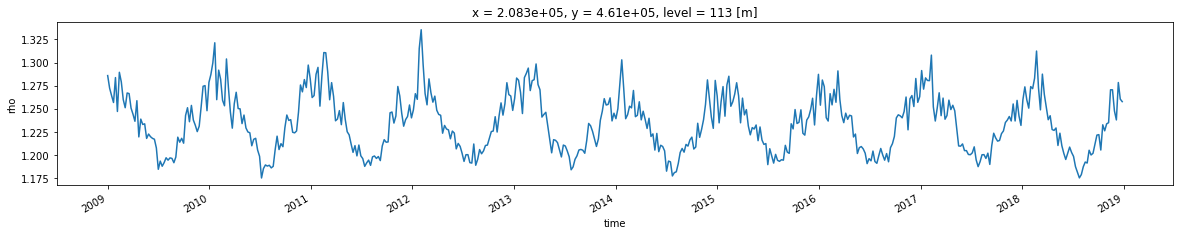

In [65]:
ts_interp.rho.resample(time="7d").mean().plot(figsize=(20,3))

## Queing multiple Points
### Using advanced indexing with `xr.Dataset.interp()` dose not scale

When passing arrays of coordinates for different wind turbines to `xarray.interp()` as done in the cell bellow, the processing time dose not scale:

- single turbine interpolation for one year: 0.7 seconds
- two turbines interpolation for one year: 11.6 seconds
    - new coordinates should be passed as `xarray.DataArray(x/y/level, dims="z", coords={"z": ["Anlage_1", ... ,"Anlage_n"]})`

In [69]:
year = 2017

size = 2
lon = np.around(np.random.uniform(6.0, 14.0, size=size),1)
lat = np.around(np.random.uniform(48.0, 55.0, size=size),1)
[x_interp,y_interp] = coor_transformation(coor=[lat,lon], engine="pyproj")
x_interp = xr.DataArray(x_interp, dims="z")#, coords={"z": ["Anlage1", "Anlage2"]})
y_interp = xr.DataArray(y_interp, dims="z")#, coords={"z": ["Anlage1", "Anlage2"]})

# load the new dimensional lambda coordinates
path = "xy_lamber_projection_values"
new_dim_coor = pd.read_csv(path)
# load the new x,y values to the netCDF data
x_coor = new_dim_coor["x"].dropna().astype("int").values
y_coor = new_dim_coor["y"].values

tsnc_data_path = f"/uba/anemos_winddata/20191029_anemosDataFull/UBA-Windatlas/TSNC-Format/wspd.10L.{year}.ts.nc"

with xr.open_dataset(tsnc_data_path,engine='h5netcdf') as ts_nc_data:
    # assign the new x,y values to the netCDF data
    ts_nc_data = ts_nc_data.assign_coords(
        coords={"x": x_coor,"y": y_coor}
    )

    ts_interp = ts_nc_data.interp(
        x=x_interp, 
        y=y_interp, 
        level=113, #xr.DataArray([113,132], dims="z", coords={"z": ["Anlage1", "Anlage2"]}), 
        method="linear")

ts_interp.wspd.load()

KeyboardInterrupt: 

In [73]:
size = 40

lon = np.around(np.random.uniform(6.0, 14.0, size=size),1)
lat = np.around(np.random.uniform(48.0, 55.0, size=size),1)
np.stack([lat, lon])

array([[54.9, 51.3, 53.3, 50.6, 52.5, 48.8, 49.7, 54.3, 52.5, 54.8, 52.2,
        54.3, 51. , 53.9, 50.3, 49.4, 50.7, 53.8, 54.4, 53.6, 49.8, 53. ,
        51.2, 52.2, 51.6, 53.4, 49.5, 51.4, 51.1, 54.4, 54. , 50.3, 51. ,
        54.1, 49.2, 51. , 50.8, 54.1, 50.2, 52.9],
       [13.7,  6.7, 13. , 12.4,  6. , 11.1,  6.3,  9.9, 12. , 10. , 13.5,
        13.1, 12.7, 10.7,  7.5,  7.2,  7.3,  6.7, 11.8, 11.8,  6.8,  9.5,
        11.6,  6.1,  9.9,  8.9,  7.4,  9.9, 12.4, 10. ,  7.9,  7.9,  9. ,
        11.7, 12.4, 11.4, 13.3,  8. ,  9.4,  8.4]])

# 2. yearly average data

The averaged data contains wind statistics of each coordinate at a certain level. In 12 directional subclases, both the average windspeed and the dominant wind direction is given.

In [ ]:
def circularHisto(xarray, dataVariable:str, grid=False):
    '''
    To Do's:
    - Add colorbar
    '''
    radii = xarray[dataVariable].values
    N = radii.size
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
    width = np.full((1, 12), 2 * np.pi / 13)[0]
    
    ax = plt.subplot(111, projection='polar')
    bars = ax.bar(theta, radii, bottom=0.0, width=width)
    # Use custom colors and opacity
    for r, bar in zip(radii, bars):
        bar.set_facecolor(plt.cm.viridis(r / radii.max()))
        bar.set_alpha(0.7)

    ax.set_theta_zero_location("N")
    if grid:
        ax.set_rticks(np.arange(0,radii.max(),2))
    else:
        ax.set_rticks([])
    
    ticks = ["N","NW","W","SW","S","SE","E","NE"]
    ax.set_xticklabels(ticks)
    
    if dataVariable == "wspd":
        ax.set_title("Average Windspeed [m/s] 2008 - 2017", pad=25)
        
    if dataVariable == "histo":
        ax.set_title("Distribution of wind directions 2008 - 2017", pad=25)
    plt.show()
    
def describingHisto(xarray):
    fig, axs = plt.subplots(1, 2)
    
    diags =("histo","wspd")
    
    for num, ax in enumerate(axs):
        ax = circularHisto(xarray, dataVariable=diags[num])

In [ ]:
path = r"windData/D-3km.E5.dirStats.140m.2008-2017.nc"

data120m = xr.open_dataset(path)
data120m

In [ ]:
point = {
    "level":114,
    "y":0,
    "x":0,
    "coor":[50,10],
    "time":pd.to_datetime(["2016-05-01"])
}

start = timeit.default_timer()

([yloc], [xloc]), nlevel  = findPoint(data120m, point)

mid = timeit.default_timer()

point_stat = getPointData(xarray=data120m, x=xloc, y=yloc)

end = timeit.default_timer()

point["x"] = xloc
point["y"] = yloc

print(f'Nearest point: {point["x"]},{point["y"]}')
print(f'Nearest point coordinates: {point_stat.lon.values},{point_stat.lat.values}')
print(f'Time to find nearest point: {mid - start}')
print(f'Time to find get point data: {end - mid}')

point_stat

In [ ]:
circularHisto(point_stat, dataVariable="histo")
circularHisto(point_stat, dataVariable="wspd", grid=True)

In [ ]:
import numpy as np
import numba
from numba import cuda, f8, uint8

n = 20
dk = 0.00001

In [ ]:

def frange(n=n, dk =dk):
    dk = dk
    X = np.arange(dk, n, dk)
    outerSum = 0
    for i in range(X.shape[0]):
        k = X[i]
        outerSum += k

%timeit frange()


In [ ]:
@numba.jit(nopython=True)
def farange(n=n, dk =dk):
    dk = dk
    #X = np.arange(dk, n, dk)
    outerSum = 0
    for i in np.arange(dk, n, dk):
        outerSum += i

%timeit farange()

In [ ]:
@numba.jit(nopython=True)
def nbrange(n=n, dk =dk):
    dk = dk
    X = np.arange(dk, n, dk)
    outerSum = 0
    for i in range(X.shape[0]):
        k = X[i]
        outerSum += k

%timeit nbrange()

In [ ]:
@cuda.jit(argtypes=[f8, uint8])
def cudarange(n=n, dk =dk):
    dk = dk
    X = np.arange(dk, n, dk)
    outerSum = 0
    for i in range(X.shape[0]):
        k = X[i]
        outerSum += k

%timeit cudarange()